In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#zipping data - will take around 5 minutes
folder = '/content/drive/MyDrive/ANPR/character_dataset/'
data='Training Data'

!(cd "{folder}" && zip -r -q data.zip "{data}")

In [6]:
#copying zip file and unzipping in colab
zip_path='/content/drive/MyDrive/ANPR/character_dataset/data.zip'

!cp "{zip_path}" .
!unzip -q data.zip
!rm data.zip

In [9]:
#****************Data augmentation**************#

import albumentations as A
import cv2
PATH='/content/Training Data'

import os

#listing all sub directories
class_dirs=os.listdir(PATH)


def augment(img,path,img_name,border_val):
    
    transforms=[
        [A.Blur(blur_limit=(2,2),p=1)],#blur 1
        [A.Blur(blur_limit=(3,3),p=1)], #blur 2

        [A.Rotate(limit=(0,15),p=1,border_mode=cv2.BORDER_CONSTANT,value=border_val)],#rotate the image clockwise
        [A.Rotate(limit=(-15,0),p=1,border_mode=cv2.BORDER_CONSTANT,value=border_val)],#rotate the image anti-clockwise
        [A.Rotate(limit=(15,30),p=1,border_mode=cv2.BORDER_CONSTANT,value=border_val)],#rotate the image clockwise
        [A.Rotate(limit=(-30,-15),p=1,border_mode=cv2.BORDER_CONSTANT,value=border_val)],#rotate the image anti-clockwise

        [A.Blur(blur_limit=(3,3),p=1),A.Rotate(limit=(-15,0),p=1,border_mode=cv2.BORDER_CONSTANT,value=border_val)],#rotate anti-clockwise and blurr
        [A.Blur(blur_limit=(3,3),p=1),A.Rotate(limit=(0,15),p=1,border_mode=cv2.BORDER_CONSTANT,value=border_val)],#rotate clockwise and blurr

        #shift scale rotate
        [A.ShiftScaleRotate(shift_limit=0.1,scale_limit=(-0.15,0.05), rotate_limit=30,p=1,border_mode=cv2.BORDER_CONSTANT,value=border_val)],
        [A.ShiftScaleRotate(shift_limit=0.1,scale_limit=(-0.15,0.05), rotate_limit=30,p=1,border_mode=cv2.BORDER_CONSTANT,value=border_val)],
        [A.ShiftScaleRotate(shift_limit=0.1,scale_limit=(-0.15,0.05), rotate_limit=30,p=1,border_mode=cv2.BORDER_CONSTANT,value=border_val)],
    ]
    
    images=[img]

    img1=cv2.dilate(img.copy(),(2,2),iterations = 1)
    images.append(img1)

    img1=cv2.erode(img.copy(),(2,2),iterations = 1)
    images.append(img1)

    img1=cv2.dilate(img.copy(),(3,3),iterations = 1)
    images.append(img1)

    img1=cv2.erode(img.copy(),(3,3),iterations = 1)
    images.append(img1)

    cnt=0
    for image in images:
        for t in transforms:
            #defining transformation
            transform=A.Compose(t)

            #applying transformation
            aug_img=transform(image=image)['image']

            #augmented image name
            aug_img_name=f'{path}/{img_name}_aug_{cnt}.jpg'

            #saving file
            cv2.imwrite(aug_img_name,np.float32(aug_img))

            cnt+=1

def delete_augmentations():
    #iterating over all directories
    for d in class_dirs:

        #listing all images in sub directory
        files=os.listdir(os.path.join(PATH,d))

        #iterating over all images
        for file in files:
            file_path=os.path.join(PATH,d,file)
            if "aug" in file:
                os.remove(file_path)
                
        
#iterating over all directories
for d in class_dirs:
    
    #listing all images in sub directory
    files=os.listdir(os.path.join(PATH,d))
    
    #iterating over all images
    for file in files:
        
        #reading image
        img=cv2.imread(os.path.join(PATH,d,file))
        img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

        #image name
        img_name=file.split('.')[0]
        
        #generating inverse of image
        img_gray=cv2.cvtColor(img.copy(), cv2.COLOR_BGR2GRAY)
        img_bw=cv2.threshold(img_gray, 0, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV)[1]
        
        #image inv name
        img_inv_name=img_name+"_inv"
        
        #saving image inv
        cv2.imwrite(f'{d}/{img_inv_name}.png',img_bw)
        
        #apply data augmentation
        augment(img,os.path.join(PATH,d),img_name,0)
        
        augment(img_bw,os.path.join(PATH,d),img_inv_name,255)

    print(f'{d} augmented, number of images: ',len(os.listdir(os.path.join(PATH,d))))
        
print("Data Augmentation Done!")                 

2 augmented, number of images:  2664
class_Q augmented, number of images:  2664
class_M augmented, number of images:  2775
5 augmented, number of images:  2664
class_Z augmented, number of images:  2664
class_B augmented, number of images:  2664
6 augmented, number of images:  2664
class_J augmented, number of images:  2664
class_R augmented, number of images:  2664
class_O augmented, number of images:  2664
7 augmented, number of images:  2664
class_F augmented, number of images:  2664
class_P augmented, number of images:  2664
class_K augmented, number of images:  2664
class_S augmented, number of images:  2664
class_L augmented, number of images:  2664
class_U augmented, number of images:  2664
class_E augmented, number of images:  2664
class_X augmented, number of images:  2664
class_A augmented, number of images:  2664
class_C augmented, number of images:  2664
class_W augmented, number of images:  2664
0 augmented, number of images:  2664
1 augmented, number of images:  2664
8 au

In [8]:
#***************************DANGER**************************#
#****************For deleting augmentations*****************#

delete_augmentations()
print("Augmented data deleted")

Augmented data deleted


In [10]:
from itertools import chain


X=[]
Y=[]

#iterating over all directories
for d in class_dirs:
    
    #listing all images in sub directory
    files=os.listdir(os.path.join(PATH,d))
    
    #iterating over all images
    for file in files:
        
        #reading image
        img=cv2.imread(os.path.join(PATH,d,file))
        
        #binarizing image
        img_gray=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img_bw=cv2.threshold(img_gray, 0, 255, cv2.THRESH_OTSU)[1]
        
        #flattening image and appending it
        X.append(list(chain.from_iterable(img_bw)))
        
        #appending label
        Y.append(file.split('_')[1])
        
print(len(Y))

96015


In [11]:
print(f"no of images: {len(X)}")
print(f"no of dimensions: {len(X[0])}")

no of images: 96015
no of dimensions: 784


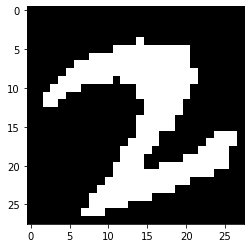

In [12]:
x0=np.reshape(X[6],(-1,28))
plt.imshow(x0, cmap="gray")

In [13]:
#converting to numpy array
X=np.array(X)

#normalising X
X=X/255

#reshaping to (28,28,1)
X=X.reshape(len(X),28,28,1)

In [14]:
from keras.utils import np_utils


#converting Y[i] to int values: 0-9 and 10-35(A-Z)
for i in range(0,len(Y)):
    if Y[i].isalpha():
        Y[i]=ord(Y[i])-ord('A')+10
    else:
        Y[i]=int(Y[i])

#one hot encoding
Y=np_utils.to_categorical(Y,36)

#converting to numpy array
Y=np.array(Y)

In [15]:
print(X.shape)
print(Y.shape)

(96015, 28, 28, 1)
(96015, 36)


In [16]:
from keras.models import Sequential
from keras.layers import Dense,Flatten
from keras.layers.convolutional import Conv2D,MaxPooling2D

In [21]:
width=28
height=28
batch_size=32
epochs=50
model=Sequential()
#Conv Layer-1
model.add(Conv2D(6,kernel_size=5,input_shape=(width,height,1),data_format='channels_last',padding='same',activation='relu'))

#Max Pool Layer-1
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

#Conv Layer-2
model.add(Conv2D(16,kernel_size=5,activation='relu'))

#Max Pool Layer-2
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

#Conv Layer-3
model.add(Conv2D(120,kernel_size=5,activation='relu'))
model.add(Flatten())

#Fully Connected Layer-1
model.add(Dense(84,activation='relu'))

#Softmax
model.add(Dense(36,activation='softmax'))

In [22]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 28, 28, 6)         156       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 10, 10, 16)        2416      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 5, 16)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 1, 1, 120)         48120     
_________________________________________________________________
flatten_1 (Flatten)          (None, 120)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 84)               

In [23]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [24]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.15, random_state=60)

print(X_train.shape)
print(X_test.shape)

(81612, 28, 28, 1)
(14403, 28, 28, 1)


In [25]:
history=model.fit(X_train,Y_train,batch_size=batch_size,epochs=epochs,validation_split = 0.15)

Epoch 1/50
2168/2168 [==============================] - 41s 4ms/step - loss: 1.0666 - accuracy: 0.6897 - val_loss: 0.1498 - val_accuracy: 0.9485
Epoch 2/50
2168/2168 [==============================] - 8s 4ms/step - loss: 0.1344 - accuracy: 0.9525 - val_loss: 0.0981 - val_accuracy: 0.9645
Epoch 3/50
2168/2168 [==============================] - 8s 4ms/step - loss: 0.0893 - accuracy: 0.9665 - val_loss: 0.1039 - val_accuracy: 0.9619
Epoch 4/50
2168/2168 [==============================] - 8s 4ms/step - loss: 0.0694 - accuracy: 0.9730 - val_loss: 0.0767 - val_accuracy: 0.9726
Epoch 5/50
2168/2168 [==============================] - 8s 4ms/step - loss: 0.0564 - accuracy: 0.9773 - val_loss: 0.0762 - val_accuracy: 0.9727
Epoch 6/50
2168/2168 [==============================] - 8s 4ms/step - loss: 0.0502 - accuracy: 0.9800 - val_loss: 0.0702 - val_accuracy: 0.9729
Epoch 7/50
2168/2168 [==============================] - 8s 4ms/step - loss: 0.0488 - accuracy: 0.9801 - val_loss: 0.0691 - val_accuracy

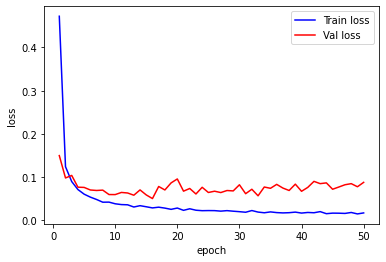

In [35]:
#Loss curve
import matplotlib.pyplot as plt
fig,ax=plt.subplots(1,1)
ax.set_xlabel('epoch')
ax.set_ylabel('loss')

x=list(range(1,epochs+1))

v=history.history['val_loss']
t=history.history['loss']

def plt_dynamic(x,y,y_1,ax,colors=['b']):
    ax.plot(x,y,'b',label='Train loss')
    ax.plot(x,y_1,'r',label='Val loss')
    plt.legend()
    fig.canvas.draw()
plt_dynamic(x,t,v,ax)

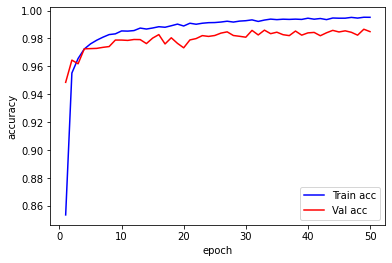

In [36]:
#Accuracy curve
fig,ax=plt.subplots(1,1)
ax.set_xlabel('epoch')
ax.set_ylabel('accuracy')

x=list(range(1,epochs+1))

va=history.history['val_accuracy']
ta=history.history['accuracy']

def plt_dynamic(x,y,y_1,ax,colors=['b']):
    ax.plot(x,y,'b',label='Train acc')
    ax.plot(x,y_1,'r',label='Val acc')
    plt.legend()
    fig.canvas.draw()
plt_dynamic(x,ta,va,ax)

In [37]:
model.save('lenet_50.h5')

In [38]:
def to_label(n):
    if n<=9:
        return str(n)
    
    return chr(n-10+ord('A'))

In [39]:
y_true=[]
y_pred=[]

pred=model.predict(X_test)
print(pred.shape)

for i in range(len(X_test)):
  # Generate arg maxes for prediction
  y_true.append(np.argmax(Y_test[i]))
  y_pred.append(np.argmax(pred[i]))


(14403, 36)


In [40]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
mat=confusion_matrix(y_true,y_pred)

labels=[to_label(i) for i in range(36)]

df_cm = pd.DataFrame(mat,labels,labels)
df_cm

,0,1,2,3,4,5,6,7,8,9,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P,Q,R,S,T,U,V,W,X,Y,Z
0,355,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,28,0,0,0,0,0,0,0,0,0,0,0
1,0,373,0,0,2,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0
2,0,0,419,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,378,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,409,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
5,0,0,0,0,0,392,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0
6,0,0,0,0,0,0,337,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
7,0,0,0,0,0,0,0,411,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
8,0,0,0,1,0,0,0,0,398,0,0,2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
9,1,0,0,0,0,0,0,0,0,416,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [41]:
from sklearn.metrics import accuracy_score
test_acc=accuracy_score(y_true, y_pred)
print(f"test accuracy: {test_acc}")

test accuracy: 0.9834756647920572
